In [1]:
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
import wandb
import random
import time
import pickle 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import numpy as np
import os
import cv2

import improved_gym

from PIL import Image
from collections import namedtuple, deque
from itertools import count

from models.on_track_cls import OnTrackClsNet
from models.rl_car_racing import DDQN
from dp_spec.img import preprocess_img
from dp_util.img import load_img, output_to_arr
from dp_util.dqn import ReplayMemory, find_eps_thres
from dp_spec.dqn import optimize_model, select_action
from cfgs.rl_car_racing import RlCarRacingCfg

C:\Users\auyin11\anaconda3\envs\rl_game_pip\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# TODO:
1. Add a large penalty if the velocity is zero

In [2]:
load_prev_md = False

use_double_dqn = True
step_waiting = 50
on_track_cls_file = 'on_track_classifier_v_2_0_5.pth'
img_num = 1
dir_auto_img = r'D:\file\data\racing\auto_img'
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))
collect_img = False

In [3]:
cfg = RlCarRacingCfg(test_mode=False, dir_data='./')

wandb.init(project=cfg.project, entity=cfg.entity,
           group=cfg.model,
           job_type="train_model",
           name= cfg.version, 
           # id=cfg.id
          )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: auyin11 (kaggle_winner). Use `wandb login --relogin` to force relogin


device: cuda


In [4]:
# load the on track classifier model and encoder
with open('ont_hot_encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)     
# extract definition of prediction output
on_track_label = encoder.categories_[0].tolist().index('on')
off_track_label = encoder.categories_[0].tolist().index('off')

on_track_cls_net = OnTrackClsNet().to(device)
on_track_cls_net.load_state_dict(torch.load(on_track_cls_file))

C:\Users\auyin11\anaconda3\envs\rl_game_pip\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<All keys matched successfully>

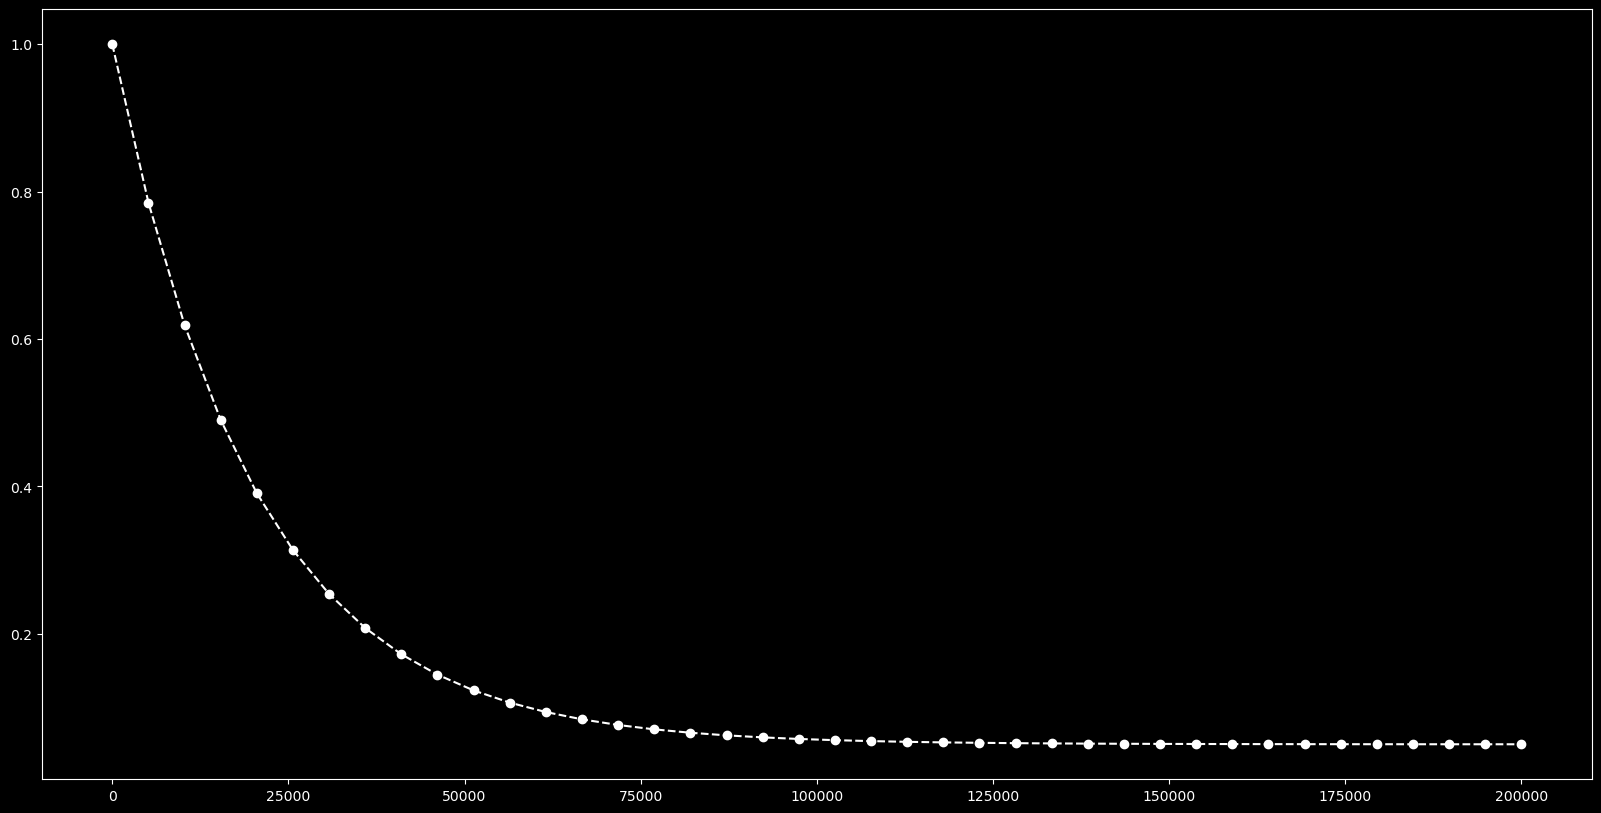

In [5]:
# preview the eps threshold
list_steps_done = np.linspace(1, 200000, num=40)
list_eps_threshold = []

for x in list_steps_done:
    list_eps_threshold.append(find_eps_thres(cfg, x))

plt.style.use('dark_background')    
plt.figure(figsize=(20,10))
plt.plot(list_steps_done, list_eps_threshold, c ="white", linestyle='dashed', marker='o')

In [6]:
env = improved_gym.make("CarRacing-v2", 
               # render_mode='human', 
               continuous=False)

n_actions = env.action_space.n

state_dim = (2, 84, 84)
input_size = state_dim[1]

policy_net = DDQN(state_dim[0], input_size, n_actions).to(device)
target_net = DDQN(state_dim[0], input_size, n_actions).to(device)
optimizer = optim.AdamW(policy_net.parameters(), lr=cfg.LR, amsgrad=True)

In [7]:
if load_prev_md:
    print(f'load the previous model {cfg.md_name.split(".")[0]}')
    
    policy_net.load_state_dict(torch.load(f'poli_{i_episode}_{cfg.md_name}'))
    target_net.load_state_dict(torch.load(f'tg_{i_episode}_{cfg.md_name}'))

    with open(f"dict_cp_{i_episode}_{cfg.md_name.split('.')[0]}.pkl", 'rb') as f:
        dict_cp = pickle.load(f)  
        
    memory = dict_cp['memory']
    list_reward_round_sum = dict_cp['list_reward_round_sum']
    list_round_avg_loss = dict_cp['list_round_avg_loss']
    steps_done = dict_cp['steps_done']
    i_episode = dict_cp['i_episode']
    eps_threshold = dict_cp['eps_threshold']
    
# start from a new records
else:
    print('start to train a new model')
    target_net.load_state_dict(policy_net.state_dict())
    
    memory = ReplayMemory(cfg.MEMORY_CAP)
    list_reward_round_sum = []
    list_round_avg_loss = []
    steps_done = 0
    i_episode = 1
    eps_threshold = cfg.EPS_START
    
# Log the network weight histograms
wandb.watch(policy_net)

start to train a new model


[]

In [8]:
while i_episode <= cfg.NUM_EPISODES:
    
    steps_done_round = 0
    list_reward_round = []
    list_loss_round = []
    list_speed = []
    
    print(f'i_episode: {i_episode}, eps_threshold: {eps_threshold:.{cfg.SF}f}')
    
    state, info = env.reset()
    prev_state = None

    # as the image is zooming in the first 50 steps and it wil affect learning, do not interact with env
    for i in range(step_waiting):
        _, _, _, _, _ = env.step(0)
        steps_done_round += 1
        
    state = preprocess_img(state)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    for t in count():
        
        steps_done += 1
        steps_done_round += 1
        eps_threshold = find_eps_thres(cfg, steps_done)
        
        if prev_state is None:
            prev_state = state
        states = torch.concat((prev_state, state)).unsqueeze(0)
        action = select_action(policy_net, states, eps_threshold, device)
        observation, reward, terminated, truncated, _ = env.step(action.item(), on_track_cls_net=on_track_cls_net,
                                                                 off_track_label=off_track_label,
                                                                 device=device)
        
        # save the img to train a on track classifier model
        if collect_img:            
            img_num += 1
            if img_num % 10 == 0:
                img = Image.fromarray(observation, 'RGB')
                img.save(os.path.join(dir_auto_img, f'{img_num}.png'))
        
        list_reward_round.append(reward)
        list_speed.append(env.true_speed)
        
        reward = torch.tensor([[reward]], device=device)
        observation = preprocess_img(observation)
        next_state = torch.tensor(observation,
                                      dtype=torch.float32, device=device).unsqueeze(0)
        done = terminated or truncated
        ts_done = torch.tensor([[done]], device=device, dtype=torch.long)
        
        # Store the transition in memory
        next_states = torch.concat((state, next_state)).unsqueeze(0)
        memory.push(states, action, next_states, reward, ts_done)
        prev_state = state
        state = next_state
        
        if len(memory) >= 1000:
            if len(memory) == 1000:
                print('start to train model')
            # Perform one step of the optimization (on the policy network)
            loss = optimize_model(use_double_dqn, policy_net, target_net, memory, optimizer,
                                  cfg.BATCH_SIZE, cfg.GAMMA, device)
            list_loss_round.append(loss)
        
        if steps_done % 1 == 0:
            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*cfg.TAU \
                    + target_net_state_dict[key]*(1-cfg.TAU)
            target_net.load_state_dict(target_net_state_dict)
        
        if done:
            sum_reward_round = np.sum(list_reward_round)
            list_reward_round_sum.append(sum_reward_round)
            avg_loss_round = np.mean([x.cpu().detach().numpy() for x in list_loss_round])
            list_round_avg_loss.append(avg_loss_round)
            avg_speed_round = np.mean(list_speed)
            
            wandb.log({'i_episode': i_episode,
                       "reward_round": sum_reward_round, 'avg_loss_round': avg_loss_round,
                      'avg_speed': avg_speed_round})
            
            i_episode += 1
            
            break

i_episode: 1, eps_threshold: 1.00000


C:\Users\auyin11\PycharmProjects\rl_game\improved_gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\auyin11\anaconda3\envs\rl_game_pip\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\auyin11\anaconda3\envs\rl_game_pip\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


i_episode: 2, eps_threshold: 0.95593
start to train model
i_episode: 3, eps_threshold: 0.91390
i_episode: 4, eps_threshold: 0.87383
i_episode: 5, eps_threshold: 0.83561
i_episode: 6, eps_threshold: 0.79917
i_episode: 7, eps_threshold: 0.76441
i_episode: 8, eps_threshold: 0.73127
i_episode: 9, eps_threshold: 0.69967
i_episode: 10, eps_threshold: 0.66953
i_episode: 11, eps_threshold: 0.64079
i_episode: 12, eps_threshold: 0.61338
i_episode: 13, eps_threshold: 0.58725
i_episode: 14, eps_threshold: 0.56233
i_episode: 15, eps_threshold: 0.53856
i_episode: 16, eps_threshold: 0.51590
i_episode: 17, eps_threshold: 0.49428
i_episode: 18, eps_threshold: 0.47367
i_episode: 19, eps_threshold: 0.45402
i_episode: 20, eps_threshold: 0.43528
i_episode: 21, eps_threshold: 0.41740
i_episode: 22, eps_threshold: 0.40036
i_episode: 23, eps_threshold: 0.38411
i_episode: 24, eps_threshold: 0.36861
i_episode: 25, eps_threshold: 0.35383
i_episode: 26, eps_threshold: 0.33973
i_episode: 27, eps_threshold: 0.32629

KeyboardInterrupt: 

In [ ]:
stop

In [14]:
env.close()

In [16]:
torch.save(policy_net.state_dict(), f'poli_{i_episode}_{cfg.md_name}')
torch.save(target_net.state_dict(), f'tg_{i_episode}_{cfg.md_name}')

dict_cp = {
    'memory': memory,
    'list_reward_round_sum': list_reward_round_sum,
    'list_round_avg_loss': list_round_avg_loss,
    'steps_done': steps_done,
    'i_episode': i_episode,
    'eps_threshold': eps_threshold
}

with open(f"dict_cp_{i_episode}_{cfg.md_name.split('.')[0]}.pkl",'wb') as output:
      pickle.dump(dict_cp, output)

<Axes: >

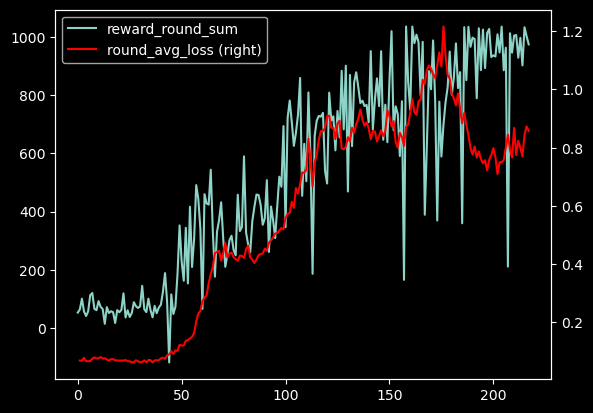

In [17]:
import pandas as pd
df_reward_round_sum = pd.DataFrame(
    {'reward_round_sum': list_reward_round_sum,
    'round_avg_loss': list_round_avg_loss
    })

ax = df_reward_round_sum.reward_round_sum.plot(legend=True)
df_reward_round_sum.round_avg_loss.plot(ax=ax,
                                        color='r',secondary_y=True, legend=True)

In [18]:
i_episode

219